In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os

In [2]:
# to have TensorFlow start out using only a minimum amount of memory and then allocate more as needed
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# set up gpu to make sure one gpu can work for multiple scripts at the same time
os.environ["CUDA_VISIBLE_DEVICES"]="0" # use the first gpu
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import backend as K

print(tf.__version__)

2.4.1


## Data Loading

In [3]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)
SAVED_IN = os.path.abspath( DIR + "/models/V27/autoencoder/")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

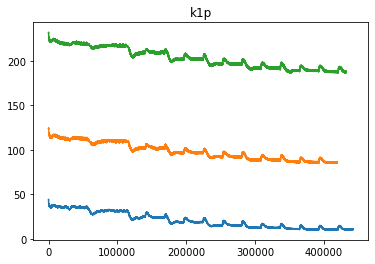

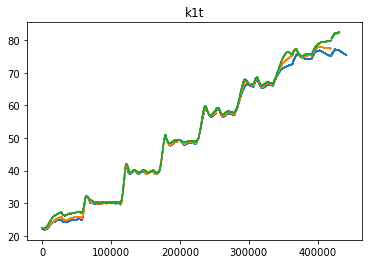

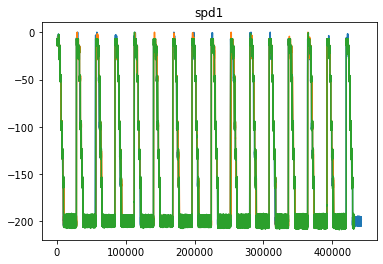

In [4]:
# load raw data and shifts
h5_p30 = h5py.File(file_list_LEM1[2], "r")
filename_p30 = file_list_LEM1[2].split(os.sep)[-1][:-3]
pklName_p30 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p30 + '.pkl'
shift_opts_freqs_all_p30 = pickle.load(open(pklName_p30, 'rb')) 

h5_p100 = h5py.File(file_list_LEM1[0], "r")
filename_p100 = file_list_LEM1[0].split(os.sep)[-1][:-3]
pklName_p100 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p100 + '.pkl'
shift_opts_freqs_all_p100 = pickle.load(open(pklName_p100, 'rb')) 

h5_p200 = h5py.File(file_list_LEM1[1], "r")
filename_p200 = file_list_LEM1[1].split(os.sep)[-1][:-3]
pklName_p200 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p200 + '.pkl'
shift_opts_freqs_all_p200 = pickle.load(open(pklName_p200, 'rb')) 


def plot3(h51,h52,h53,key):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(key)
    ax.plot(h51[key])
    ax.plot(h52[key])
    ax.plot(h53[key])
plot3(h5_p30,h5_p100,h5_p200,'k1p')
plot3(h5_p30,h5_p100,h5_p200,'k1t')
plot3(h5_p30,h5_p100,h5_p200,'spd1')

## Data Extraction

In [5]:
N = 100 # ignore first N points to make the shift possible

spd_p30 = np.round(h5_p30['spd1'][N:],decimals=1)
spd_p100 = np.round(h5_p100['spd1'][N:],decimals=1)
spd_p200 = np.round(h5_p200['spd1'][N:],decimals=1)

pos_p30 = np.round(h5_p30['pos1'][N:],decimals=1)
pos_p100 = np.round(h5_p100['pos1'][N:],decimals=1)
pos_p200 = np.round(h5_p200['pos1'][N:],decimals=1)

k1t_p30 = np.round(h5_p30['k1t'][N:],decimals=1)
k1t_p100 = np.round(h5_p100['k1t'][N:],decimals=1)
k1t_p200 = np.round(h5_p200['k1t'][N:],decimals=1)

ip1k1_p30 = np.round(h5_p30['ip1k1'][N:],decimals=1)
ip1k1_p100 = np.round(h5_p100['ip1k1'][N:],decimals=1)
ip1k1_p200 = np.round(h5_p200['ip1k1'][N:],decimals=1)

len_p30 =pos_p30.shape[0]
len_p100 =pos_p100.shape[0]
len_p200 =pos_p200.shape[0]

print("length:")
print(len_p30)
print(len_p100)
print(len_p100)
print("max:")
print(max(pos_p30))
print(max(pos_p100))
print(max(pos_p200))
print("min:")
print(min(pos_p30))
print(min(pos_p100))
print(min(pos_p200))

length:
441946
419201
419201
max:
124.8
124.8
124.8
min:
-135.0
-134.9
-134.9


In [6]:
# TODO: try to change the way to handle complex numbers
# currently real and imag parts of a complex are seperated and even not adjacent!
# possible solution: add abs as a feature as well

s21_p30 = np.array(h5_p30['S21_P1_LEM1'])
dataset_p30 = []
for j in range (121):
    index = np.arange(N,len(h5_p30['t'])) - shift_opts_freqs_all_p30[j,N:].round().astype(int)
    dataset_p30.append(s21_p30[index,j].real)
    dataset_p30.append(s21_p30[index,j].imag)
dataset_p30 = np.array(dataset_p30)

s21_p100 = np.array(h5_p100['S21_P1_LEM1'])
dataset_p100 = []
for j in range (121):
    index = np.arange(N,len(h5_p100['t'])) - shift_opts_freqs_all_p100[j,N:].round().astype(int)
    dataset_p100.append(s21_p100[index,j].real)
    dataset_p100.append(s21_p100[index,j].imag)
dataset_p100 = np.array(dataset_p100)

s21_p200 = np.array(h5_p200['S21_P1_LEM1'])
dataset_p200 = []
for j in range (121):
    index = np.arange(N,len(h5_p200['t'])) - shift_opts_freqs_all_p200[j,N:].round().astype(int)
    dataset_p200.append(s21_p200[index,j].real)
    dataset_p200.append(s21_p200[index,j].imag)
dataset_p200 = np.array(dataset_p200)

print(dataset_p30.shape)
print(dataset_p100.shape)
print(dataset_p200.shape)

(242, 441946)
(242, 419201)
(242, 431830)


In [7]:
h5_p30.close()
h5_p100.close()
h5_p200.close()

## Data Preprocessing for Autoencoder

**Pseudo code:**

for each specific position:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;find the indicies of them in all three datasets and store the corresponding s21 as input of the autoencoder;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;find the s21 with chamber pressure 100 bar and mean temperature (≈ 50℃) as the output of the autoencoder and store them;
    
    
    

In [8]:
MAX = min(max(pos_p30),max(pos_p100),max(pos_p200))
MIN = max(min(pos_p30),min(pos_p100),min(pos_p200))

In [9]:
# # test for a specific p
# p = 0
# ind_p30 = np.where(pos_p30==p)[0]
# ind_p100 = np.where(pos_p100==p)[0]
# ind_p200 = np.where(pos_p200==p)[0]
# L = ind_p30.shape[0] + ind_p100.shape[0] + ind_p200.shape[0]

# # indicies with chamber pressure 100 and temperature in the range of [48,52]
# ind_p100_t50 = np.where(np.logical_and(k1t_p100>=48, k1t_p100<=52))[0]

# # randomly choose one point as the ground choo
# gt = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
    
# x_auto_ = np.concatenate((dataset_p30[:,ind_p30],dataset_p100[:,ind_p100],dataset_p200[:,ind_p200]),axis=1) # shape (242,L)
# y_auto_ = np.array(L * [dataset_p100[:,gt]]) # shape (L,242)


In [10]:
np.random.seed(42)
x_auto = []
y_auto = []

for p in np.arange(MIN,MAX+0.1,0.1):
    p = np.round(p,decimals=1)
    ind_p30 = np.where(pos_p30==p)[0]
    ind_p100 = np.where(pos_p100==p)[0]
    ind_p200 = np.where(pos_p200==p)[0]
    
    if ind_p30.size == 0:
        print("There is no data with position {} in dataset_p30".format(p))
        continue
    if ind_p100.size == 0:
        print("There is no data with position {} in dataset_p100".format(p))
        continue
    if ind_p200.size == 0:
        print("There is no data with position {} in dataset_p200".format(p))
        continue
        
    L = ind_p30.shape[0] + ind_p100.shape[0] + ind_p200.shape[0]
    
    try:
        # indicies with chamber pressure 100 and temperature in the range of [48,52], ip1k1 < 5 bar
        ind_p100_t50 = np.where(np.logical_and(k1t_p100>=48, k1t_p100<=52, ip1k1_p100<5))[0]
    
        # randomly choose one point as the ground choo
        gt = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
        
    except:
        print ("Search range of ground truth has to be extended for position {}".format(p))
        # indicies with chamber pressure 100 and temperature in the range of [45,55], ip1k1 < 5 bar
        ind_p100_t50 = np.where(np.logical_and(k1t_p100>=45, k1t_p100<=55, ip1k1_p100<5))[0]
        # randomly choose one point as the ground choo
        gt = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
        print ("We have to use the temperature {} instead\n".format(k1t_p100[gt]))
        
    x_auto_ = np.concatenate((dataset_p30[:,ind_p30],dataset_p100[:,ind_p100],dataset_p200[:,ind_p200]),axis=1) # shape (242,L)
    y_auto_ = np.array(L * [dataset_p100[:,gt]]) # shape (L,242)
    
    x_auto.append(x_auto_.T)
    y_auto.append(y_auto_)
    
x_auto = np.vstack(x_auto)
y_auto = np.vstack(y_auto)

print("shapes")
print(x_auto.shape)
print(y_auto.shape)

Search range of ground truth has to be extended for position -23.2
We have to use the temperature 52.6 instead

Search range of ground truth has to be extended for position -19.3
We have to use the temperature 47.6 instead

shapes
(1292976, 242)
(1292976, 242)


In [11]:
# result dictionary
d = {
    "abs":[
            np.mean(abs(x_auto)),
            np.mean(abs(y_auto))],

    "std":[
            np.std(abs(x_auto)),
            np.std(abs(y_auto))],
}
pd.DataFrame.from_dict(d, orient='index',
                       columns=['All', 'Ground Truth'])

,All,Ground Truth
abs,0.119339,0.116808
std,0.096906,0.092123


In [12]:
# Evaluation before autoencoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

y_true = x_auto.flatten()
y_pred = y_auto.flatten()

# Prevent division by zero 
ind = np.where(np.logical_and(y_true>=-K.epsilon(), y_true<=K.epsilon()))[0]
y_true[ind] = K.epsilon()

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAE: {}".format(mae))
print("MAPE: {}%".format(mape))

MAE: 0.03270889073610306
MAPE: 28.045320510864258%


### Train test split

In [13]:
from sklearn.model_selection import train_test_split

x_auto_train, x_auto_test, y_auto_train, y_auto_test,= train_test_split(x_auto, y_auto, test_size=0.2, random_state=42)

print(x_auto_train.shape)
print(x_auto_test.shape)

(1034380, 242)
(258596, 242)


### Normalize the data to [0,1]

mean, max, min based on x_auto_train or y_auto_train?

In [14]:
min_val = tf.reduce_min(x_auto_train)
max_val = tf.reduce_max(x_auto_train)

x_auto_train = (x_auto_train - min_val) / (max_val - min_val)
x_auto_test = (x_auto_test - min_val) / (max_val - min_val)
y_auto_train = (y_auto_train - min_val) / (max_val - min_val)
y_auto_test = (y_auto_test - min_val) / (max_val - min_val)

# x_auto_train = tf.cast(x_auto_train, tf.float32)
# x_auto_test = tf.cast(x_auto_test, tf.float32)
# y_auto_train = tf.cast(y_auto_train, tf.float32)
# y_auto_test = tf.cast(y_auto_test, tf.float32)

## Autoencoder

In [15]:
LATENT = 16
MODEL_NAME = "autoencoder_tiny16_ip1k1_N" 

In [16]:
class AutoEncoder_tiny16(Model):
  def __init__(self):
    super(AutoEncoder_tiny16, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"), # instead of 128 as in tiny32
      layers.Dense(LATENT, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(242, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

autoencoder = AutoEncoder_tiny16()

autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(
                            x_auto_train,
                            y_auto_train, 
                            epochs=20, 
                            batch_size=512,
                            validation_data=(x_auto_test, y_auto_test),
                            callbacks=[callback],
                            shuffle=True,
                            verbose=0
)

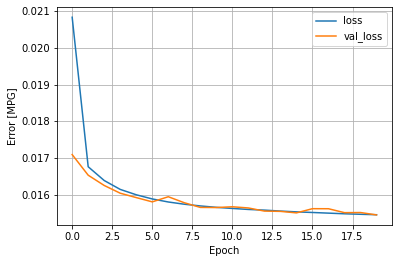

In [18]:
plot_loss(history)

In [19]:
autoencoder.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\autoencoder_tiny16_ip1k1_N\assets


In [20]:
# MODEL_NAME = "autoencoder_tiny16_ip1k1_N" 
# autoencoder = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [21]:
# Evaluation after autoencoder
encoded_imgs = autoencoder.encoder(x_auto_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.metrics import mean_absolute_error

y_true = y_auto_test.numpy().flatten()  
y_pred = decoded_imgs.flatten()

# Prevent division by zero 
ind = np.where(np.logical_and(y_true>=-K.epsilon(), y_true<=K.epsilon()))[0]
y_true[ind] = K.epsilon()

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAE: {}".format(mae))
print("MAPE: {}%".format(mape))

MAE: 0.015453454107046127
MAPE: 0.03446784242987633%


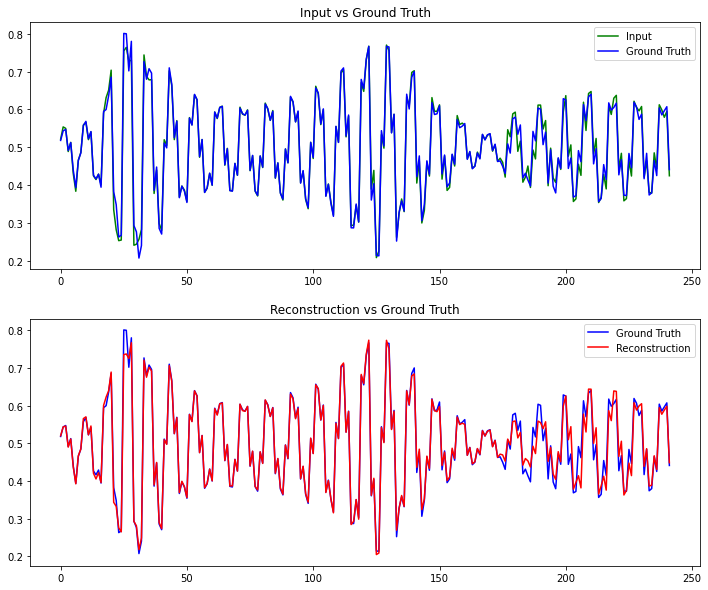

In [22]:
SAMPLE = 35138

# plot the Error between input and reconstruction as well as reconstruction and ground truth
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))


ax1.set_title("Input vs Ground Truth")
ax1.plot(x_auto_test[SAMPLE], 'g')
ax1.plot(y_auto_test[SAMPLE], 'b')
# ax1.fill_between(np.arange(242), decoded_imgs[SAMPLE], y_auto_test[SAMPLE], color='lightcoral')
ax1.legend(labels=["Input", "Ground Truth", "Error"])

# ax1.set_title("Input vs Reconstruction")
# ax1.plot(x_auto_test[SAMPLE], 'g')
# ax1.plot(decoded_imgs[SAMPLE], 'r')
# # ax1.fill_between(np.arange(242), decoded_imgs[SAMPLE], y_auto_test[SAMPLE], color='lightcoral')
# ax1.legend(labels=["Input", "Reconstruction", "Error"])

ax2.set_title("Reconstruction vs Ground Truth")
ax2.plot(y_auto_test[SAMPLE], 'b')
ax2.plot(decoded_imgs[SAMPLE], 'r')
# ax2.fill_between(np.arange(242), decoded_imgs[SAMPLE], y_auto_test[SAMPLE], color='lightcoral')
ax2.legend(labels=["Ground Truth", "Reconstruction", "Error"])


## Data Preprocessing for NN Training

### Encoding

In [23]:
X = np.concatenate((dataset_p30.T,dataset_p100.T,dataset_p200.T))
y1 = np.concatenate((pos_p30,pos_p100,pos_p200)).T
y2 = np.concatenate((ip1k1_p30,ip1k1_p100,ip1k1_p200)).T
# y = np.array([y1,y2])

print(X.shape)
print(y1.shape)
print(y2.shape)

(1292977, 242)
(1292977,)
(1292977,)


In [24]:
MODEL_NAME = "autoencoder_tiny16_ip1k1_N" 
autoencoder = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [25]:
# use the same normalization for autoencoder
X_norm = (X - min_val) / (max_val - min_val)

# encoding and decoding
X_encoded = autoencoder.encoder(X_norm).numpy()
X_decoded = autoencoder.decoder(X_encoded).numpy()

print(X_encoded.shape)
print(X_decoded.shape)

(1292977, 16)
(1292977, 242)


### End stroke

In [26]:
#  positions bigger or smaller than 100 or 10 mm
p100 = np.where(y1>100)[0]
p10 = np.where(y1>10)[0]
n100 = np.where(y1<-100)[0]
n10 = np.where(y1<-10)[0]

#  positions within in or outside absolute value 100 or 10 mm
pos_in_100 = np.array(list(set(np.arange(y1.shape[0]))-(set(p100)|set(n100))))
pos_out_100 =  np.sort(np.concatenate((p100,n100)))
pos_in_10 = np.array(list(set(np.arange(y1.shape[0]))-(set(p10)|set(n10))))
pos_out_10 =  np.sort(np.concatenate((p10,n10)))

## NN Training Based on Encoded Data

### NN Training for Position

In [27]:
GT = ['pos']
Y = y1

### Train test split wit indicies

In [28]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_encoded, Y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034381, 16)
(1034381,)
(258596, 16)
(258596,)


### 64-neurons NN Model

In [29]:
NEURONS = 64
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"

In [30]:
def NN_4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [31]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_4(normalizer)
NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 16)                33        
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,186
Trainable params: 1,153
Non-trainable params: 33
_________________________________________________________________


In [32]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=0, epochs=50)

Wall time: 7min 33s


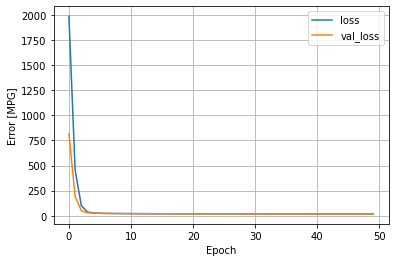

In [33]:
plot_loss(history)

In [34]:
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\NN_tiny16_64_pos_ip1k1_N\assets


In [35]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos,17.727633,17.823128,4.21042,4.221745


In [36]:
# save
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\NN_tiny16_64_pos_ip1k1_N\assets


In [37]:
# load
NEURONS = 64
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [38]:
# evaluation on both training and test sets

y_ = NN.predict(X_encoded)

if len(y_.shape)==1:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()
elif len(y_.shape)==2:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()

In [39]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [40]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,17.824725,4.218923
1,within 100,26.170833,5.115601
2,outside 100,7.343346,2.691878
3,within 10,36.621290,5.967755
4,outside 10,16.879453,4.102678
5,>100,4.882927,2.209456
6,<-100,9.811417,3.062107
7,>10,12.370235,3.516201
8,<-10,21.763861,4.633616


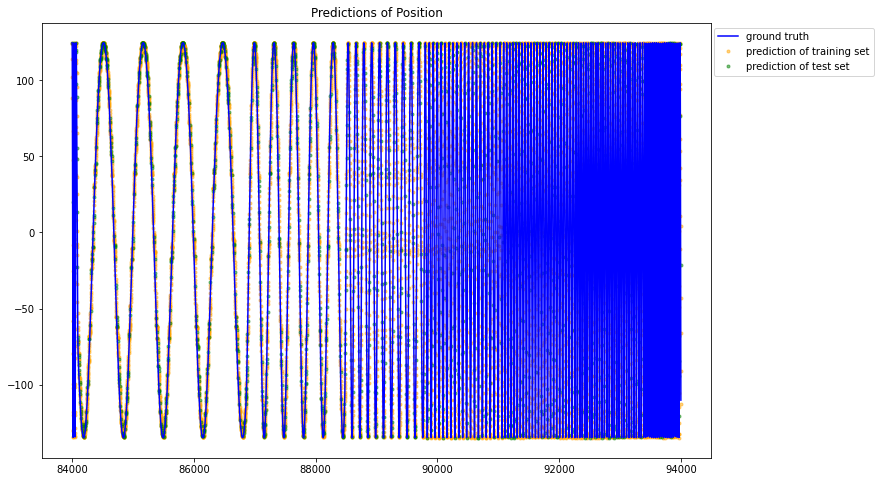

In [41]:
F = 84000
L = F+10000
plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

#### zoom in 

test root_mean_squared_error for this section is 5.4204901123122955


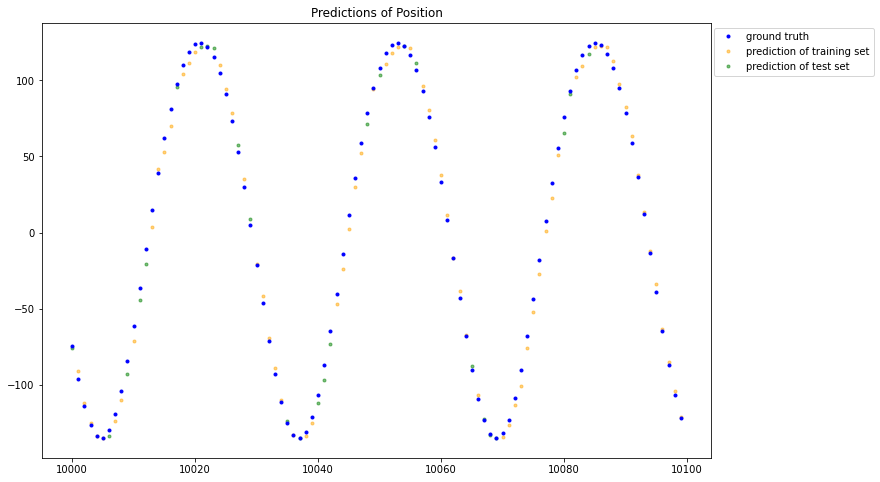

In [42]:
# high speed area
F = 10000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 7.524363657771544


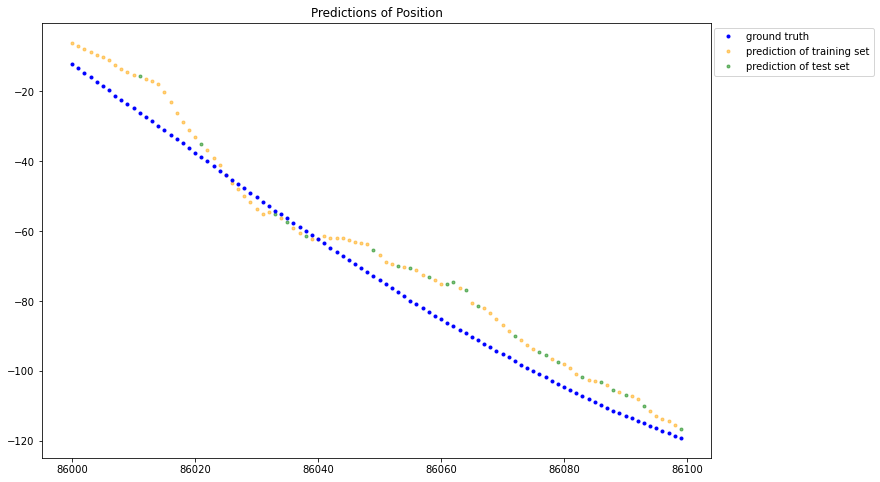

In [43]:
# low speed area
F = 86000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 3.913895386618268


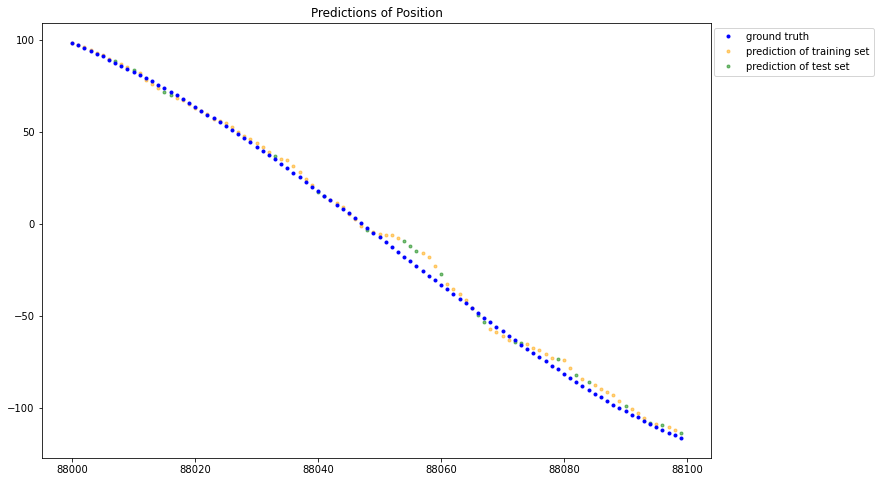

In [44]:
# middle speed area
F = 88000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

### 32-neurons NN Model

In [45]:
NEURONS = 32
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"

In [46]:
def NN_4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [47]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_4(normalizer)
NN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 16)                33        
_________________________________________________________________
dense_6 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 610
Trainable params: 577
Non-trainable params: 33
_________________________________________________________________


In [48]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=0, epochs=50)

Wall time: 7min 45s


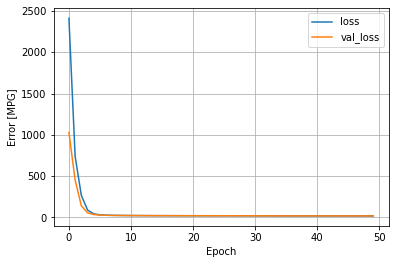

In [49]:
plot_loss(history)

In [50]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos,18.643789,18.62244,4.317845,4.315372


In [51]:
# save
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\NN_tiny16_32_pos_ip1k1_N\assets


In [52]:
# load
NEURONS = 32
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [53]:
# evaluation on both training and test sets

y_ = NN.predict(X_encoded)

if len(y_.shape)==1:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()
elif len(y_.shape)==2:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()

In [54]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [55]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,18.623764,4.315526
1,within 100,27.822960,5.274684
2,outside 100,7.071041,2.658921
3,within 10,39.204235,6.194807
4,outside 10,17.588780,4.193638
5,>100,4.856302,2.201933
6,<-100,9.292669,3.044322
7,>10,13.171614,3.627036
8,<-10,22.373477,4.724208


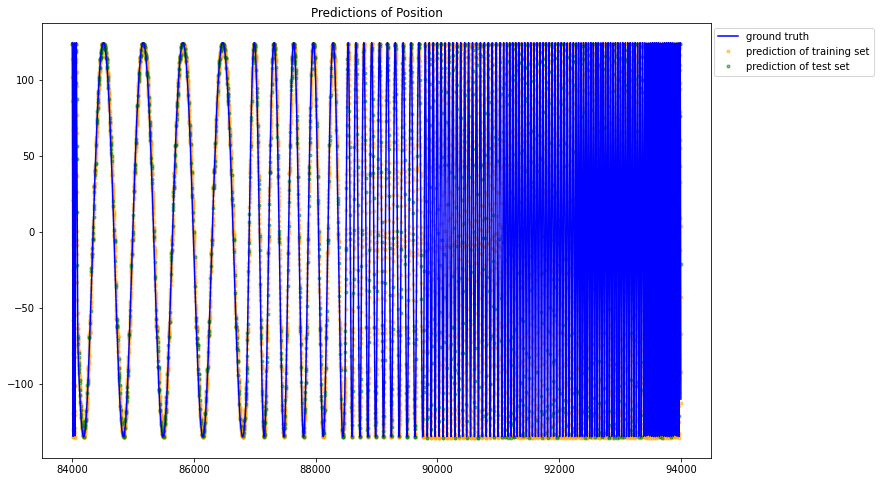

In [56]:
F = 84000
L = F+10000
plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

#### zoom in 

test root_mean_squared_error for this section is 5.9960865842765605


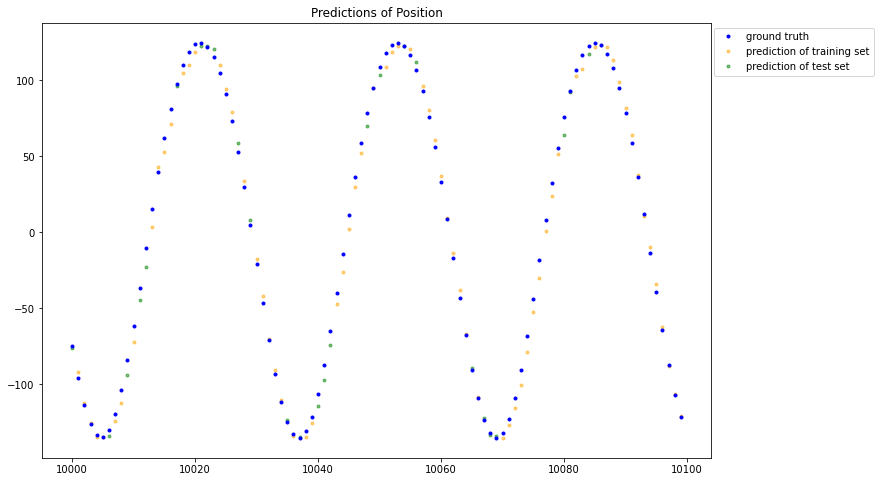

In [57]:
# high speed area
F = 10000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 7.5373517049158085


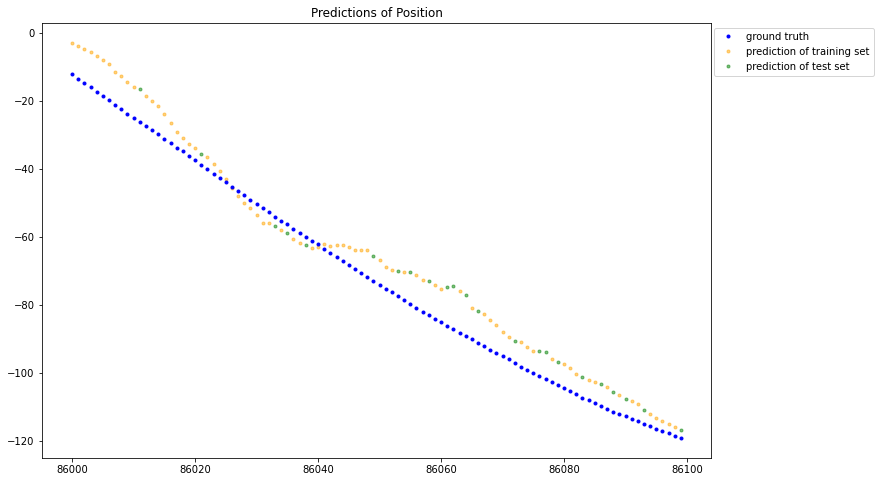

In [58]:
# low speed area
F = 86000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 3.992674606997286


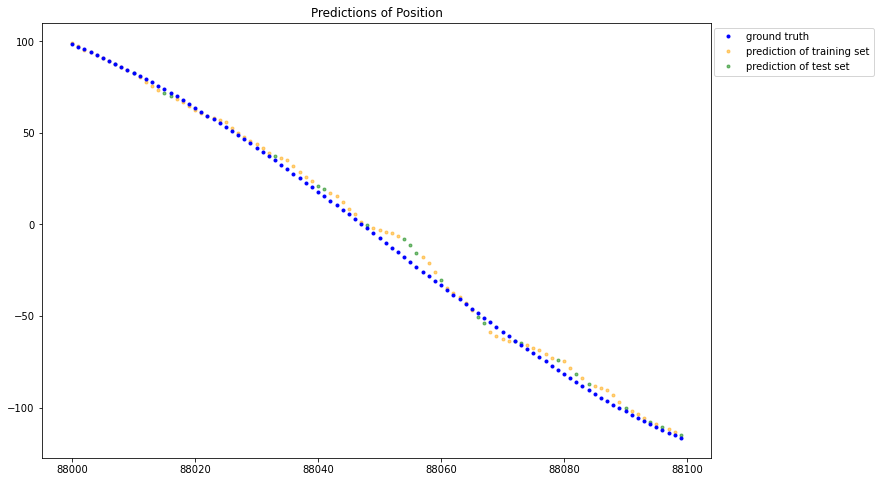

In [59]:
# middle speed area
F = 88000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

### 16-neurons NN Model

In [60]:
NEURONS = 16
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"

In [61]:
def NN_4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [62]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_4(normalizer)
NN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 16)                33        
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 322
Trainable params: 289
Non-trainable params: 33
_________________________________________________________________


In [63]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=0, epochs=50)

Wall time: 7min 32s


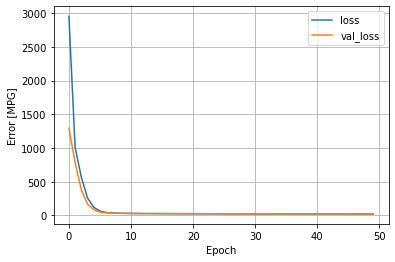

In [64]:
plot_loss(history)

In [65]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos,21.728853,21.760054,4.661422,4.664767


In [66]:
# save
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\NN_tiny16_16_pos_ip1k1_N\assets


In [67]:
# load
NEURONS = 16
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [68]:
# evaluation on both training and test sets

y_ = NN.predict(X_encoded)

if len(y_.shape)==1:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()
elif len(y_.shape)==2:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()

In [69]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [70]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,21.791452,4.664186
1,within 100,33.111098,5.753405
2,outside 100,7.575784,2.734792
3,within 10,40.268159,6.289694
4,outside 10,20.862266,4.561009
5,>100,4.996254,2.208717
6,<-100,10.163337,3.175804
7,>10,15.001648,3.872568
8,<-10,27.210517,5.198412


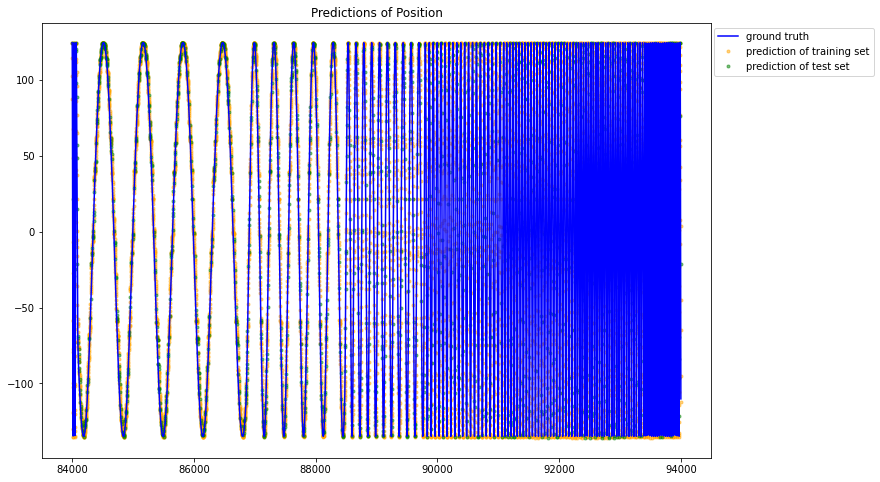

In [71]:
F = 84000
L = F+10000
plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

#### zoom in 

test root_mean_squared_error for this section is 7.309984285949384


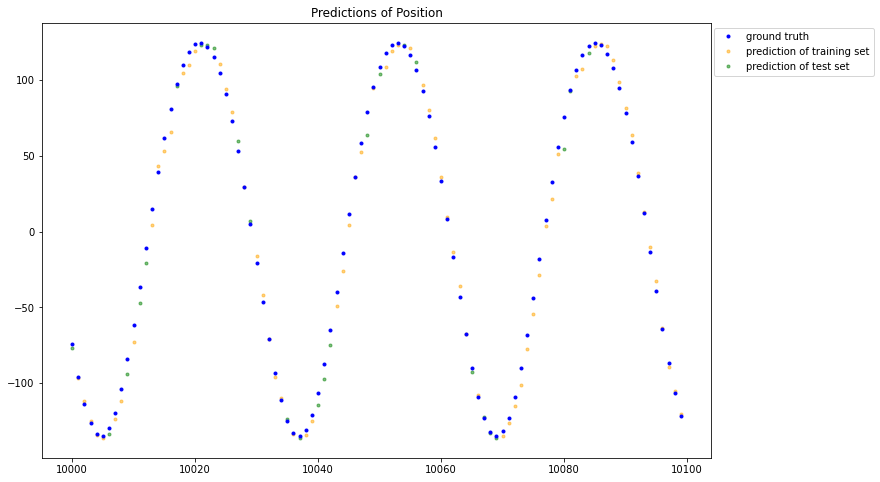

In [72]:
# high speed area
F = 10000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 9.00140852438601


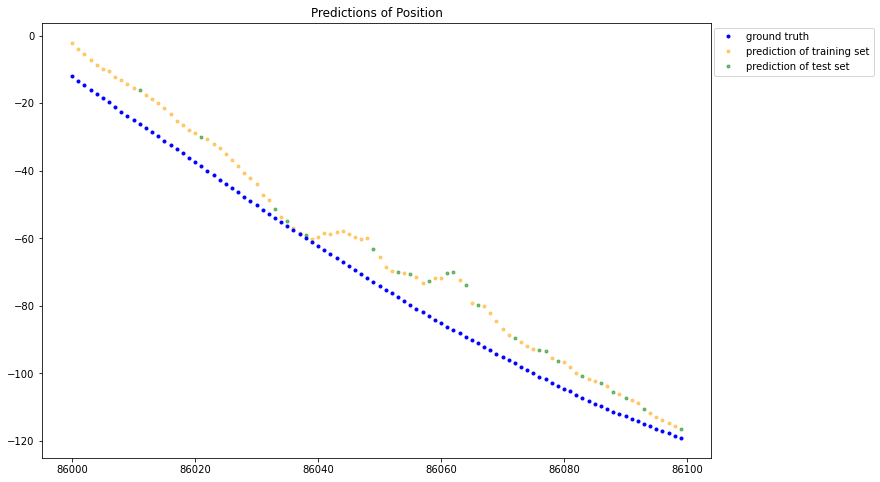

In [73]:
# low speed area
F = 86000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 4.069215219083423


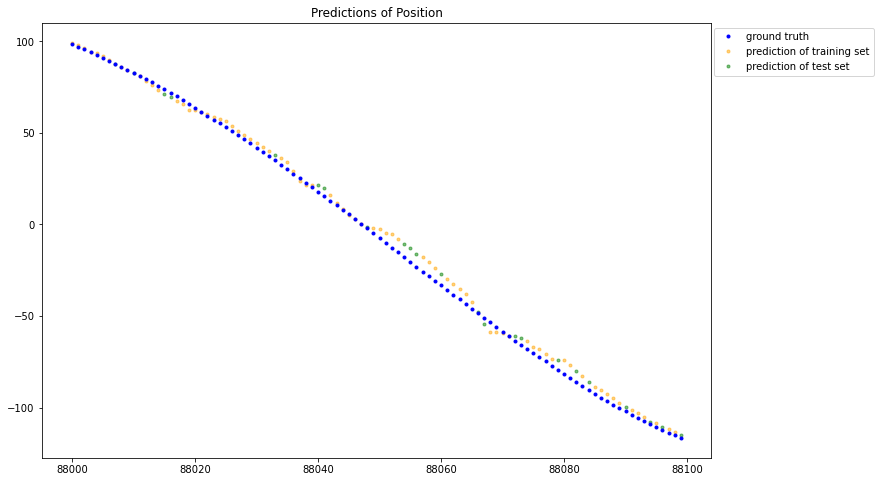

In [74]:
# middle speed area
F = 88000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

### 8-neurons NN Model

In [75]:
NEURONS = 8
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"

In [76]:
def NN_4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [77]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_4(normalizer)
NN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 16)                33        
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 178
Trainable params: 145
Non-trainable params: 33
_________________________________________________________________


In [78]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=0, epochs=50)

Wall time: 7min 34s


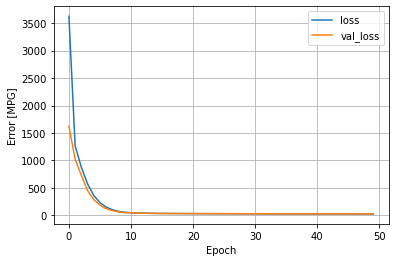

In [79]:
plot_loss(history)

In [80]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos,23.653723,23.558731,4.863509,4.853734


In [81]:
# save
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\NN_tiny16_8_pos_ip1k1_N\assets


In [82]:
#load
NEURONS = 8
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"
NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [83]:
# evaluation on both training and test sets

y_ = NN.predict(X_encoded)

if len(y_.shape)==1:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()
elif len(y_.shape)==2:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()

In [84]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [85]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,23.571827,4.853533
1,within 100,36.001545,6.000117
2,outside 100,7.962086,2.806589
3,within 10,52.490876,6.994701
4,outside 10,22.117500,4.697598
5,>100,5.537837,2.348323
6,<-100,10.393875,3.194926
7,>10,16.940879,4.115854
8,<-10,27.724842,5.242277


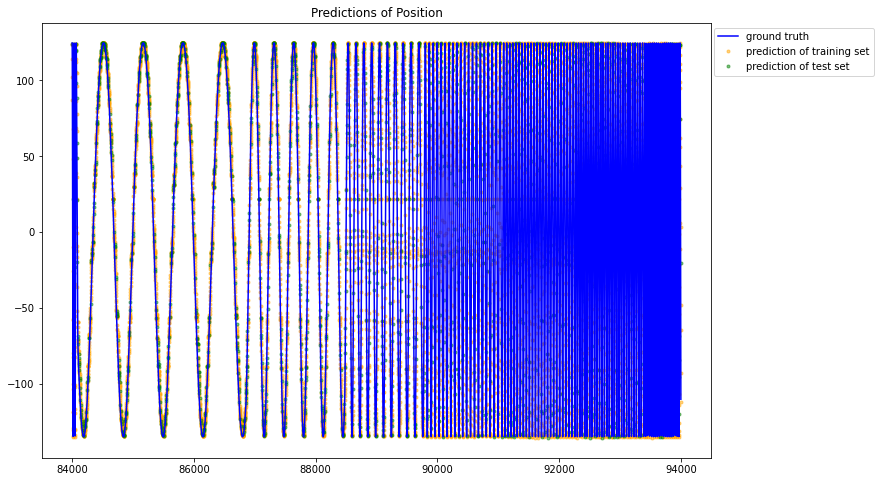

In [86]:
F = 84000
L = F+10000
plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

#### zoom in 

test root_mean_squared_error for this section is 6.592304461082507


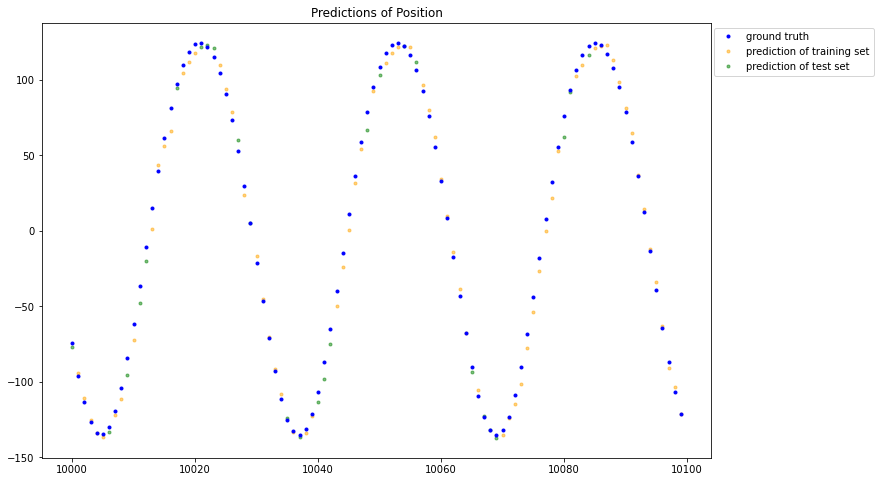

In [87]:
# high speed area
F = 10000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 8.524273071358923


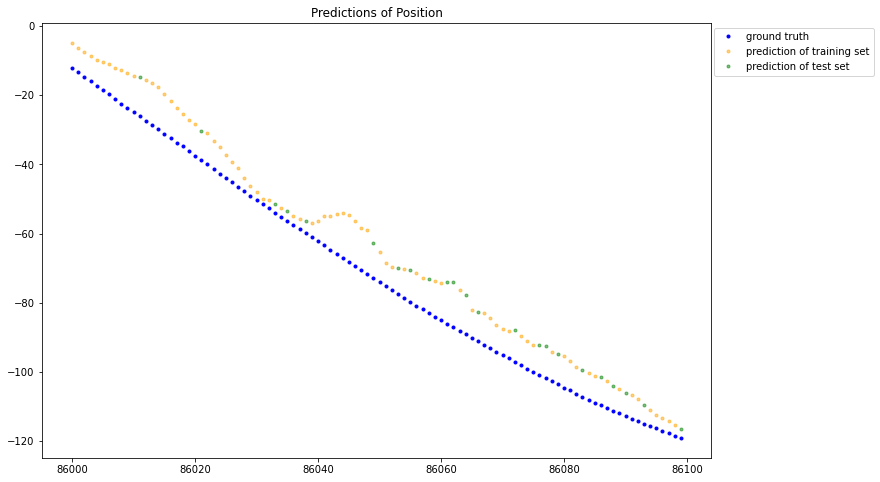

In [88]:
# low speed area
F = 86000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 4.259598357078835


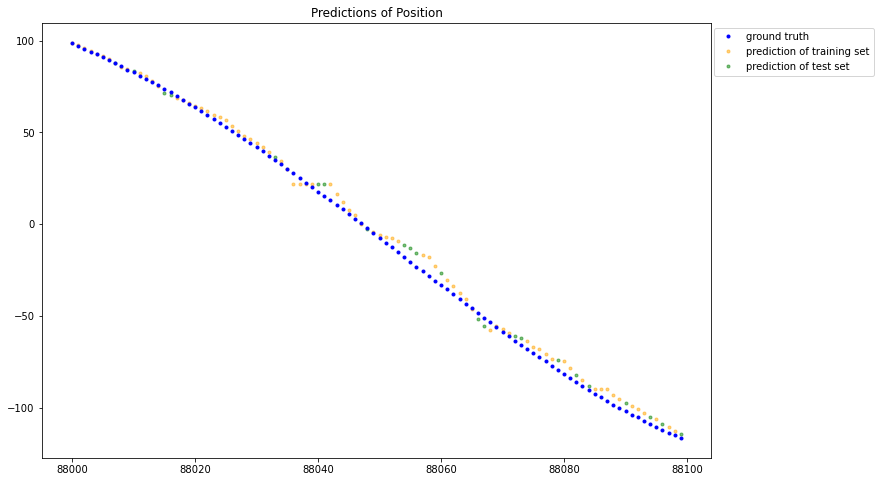

In [89]:
# middle speed area
F = 88000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

### 4-neurons NN Model

In [90]:
NEURONS = 4
MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"

In [91]:
def NN_4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(NEURONS, kernel_initializer='normal',activation='relu'),
      layers.Dense(1,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics = tf.keras.metrics.RootMeanSquaredError()
  )
  return model

In [92]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_4(normalizer)
NN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 16)                33        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 106
Trainable params: 73
Non-trainable params: 33
_________________________________________________________________


In [93]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    # validation_split = 0.125,
    validation_data=(X_test, y_test),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=0, epochs=50)

Wall time: 7min 35s


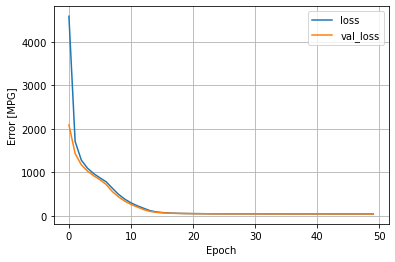

In [94]:
plot_loss(history)

In [95]:
# save
NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\NN_tiny16_4_pos_ip1k1_N\assets


In [96]:
# load
# NEURONS = 4
# MODEL_NAME = F"NN_tiny16_{NEURONS}_pos_ip1k1_N"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [97]:
err_dict = {
    'Output':GT,
    'MSE train' : history.history['loss'][-1],
    'MSE test' : history.history['val_loss'][-1],
    'RMSE train' : history.history['root_mean_squared_error'][-1],
    'RMSE test' : history.history['val_root_mean_squared_error'][-1]
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE train,MSE test,RMSE train,RMSE test
0,pos,45.422199,45.273891,6.739599,6.728588


In [98]:
# evaluation on both training and test sets

y_ = NN.predict(X_encoded)

if len(y_.shape)==1:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()
elif len(y_.shape)==2:
    y_train_ = y_[idx_train_sort].squeeze()
    y_test_ =y_[idx_test_sort].squeeze()

In [99]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = Y[idx_test_sort] - y_test_
err_in_100 = Y[idx_in_100] - y_[idx_in_100].flatten()
err_out_100 = Y[idx_out_100] - y_[idx_out_100].flatten()
err_in_10 = Y[idx_in_10] - y_[idx_in_10].flatten()
err_out_10 = Y[idx_out_10] - y_[idx_out_10].flatten()
err_p100 = Y[idx_p100] - y_[idx_p100].flatten()
err_n100 = Y[idx_n100] - y_[idx_n100].flatten()
err_p10 = Y[idx_p10] - y_[idx_p10].flatten()
err_n10 = Y[idx_n10] - y_[idx_n10].flatten()

In [100]:
# Evaluation of position predictions on end stroke in test set

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:])),
             np.mean(np.square(err_in_100[:])),
             np.mean(np.square(err_out_100[:])),
             np.mean(np.square(err_in_10[:])),
             np.mean(np.square(err_out_10[:])),
             np.mean(np.square(err_p100[:])),
             np.mean(np.square(err_n100[:])),
             np.mean(np.square(err_p10[:])),
             np.mean(np.square(err_n10[:]))],
    
    'std of position predictions' : [np.std(err_test_set[:]),
             np.std(err_in_100[:]),
             np.std(err_out_100[:]),
             np.std(err_in_10[:]),
             np.std(err_out_10[:]),
             np.std(err_p100[:]),
             np.std(err_n100[:]),
             np.std(err_p10[:]),
             np.std(err_n10[:])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,45.268660,6.727584
1,within 100,74.675279,8.640780
2,outside 100,8.338642,2.886905
3,within 10,106.431058,9.880611
4,outside 10,42.192828,6.495379
5,>100,7.011593,2.635621
6,<-100,9.669818,3.107209
7,>10,44.517600,6.642052
8,<-10,39.674623,6.248089


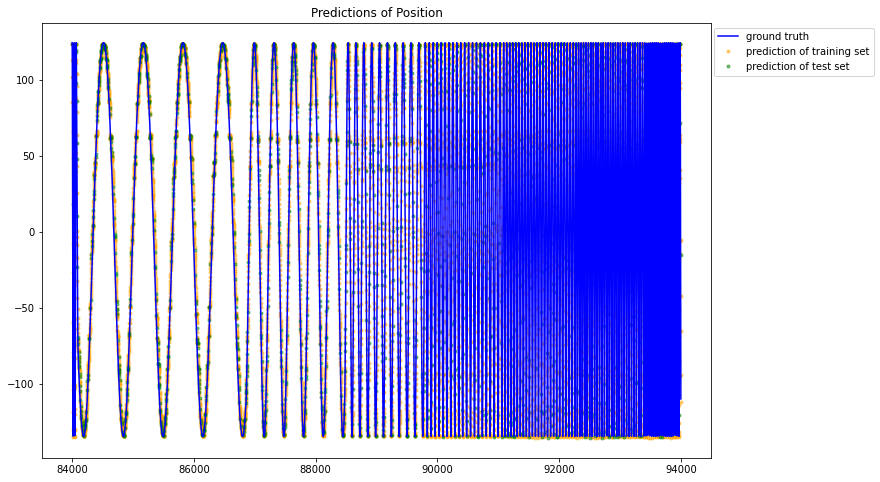

In [101]:
F = 84000
L = F+10000
plot_one_gt_train_test(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

#### zoom in 

test root_mean_squared_error for this section is 9.744921960669352


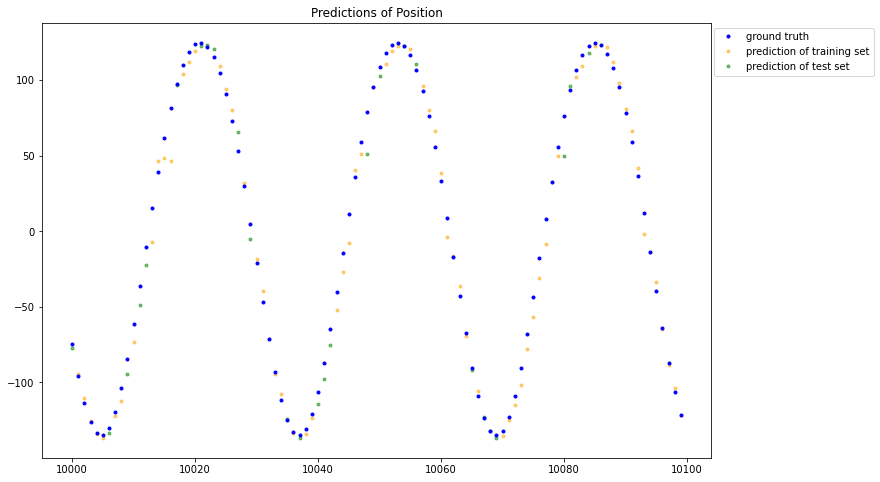

In [102]:
# high speed area
F = 10000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 9.680984849131919


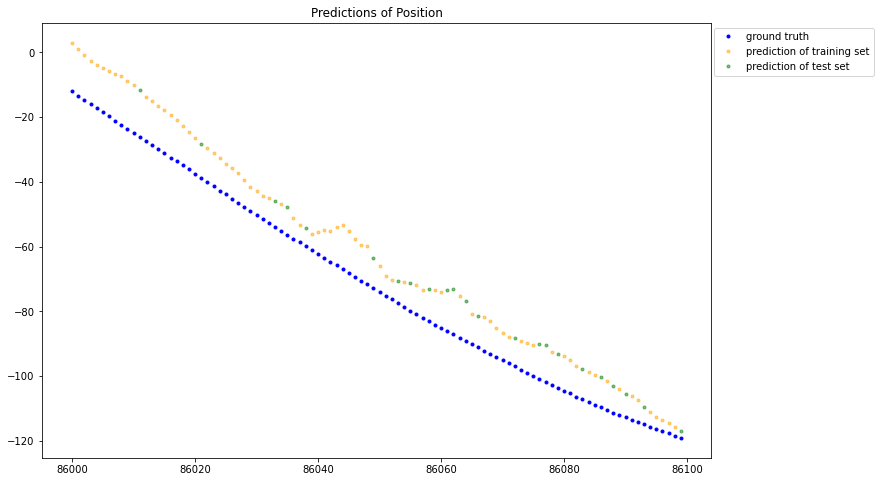

In [103]:
# low speed area
F = 86000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")

test root_mean_squared_error for this section is 5.9163777119474315


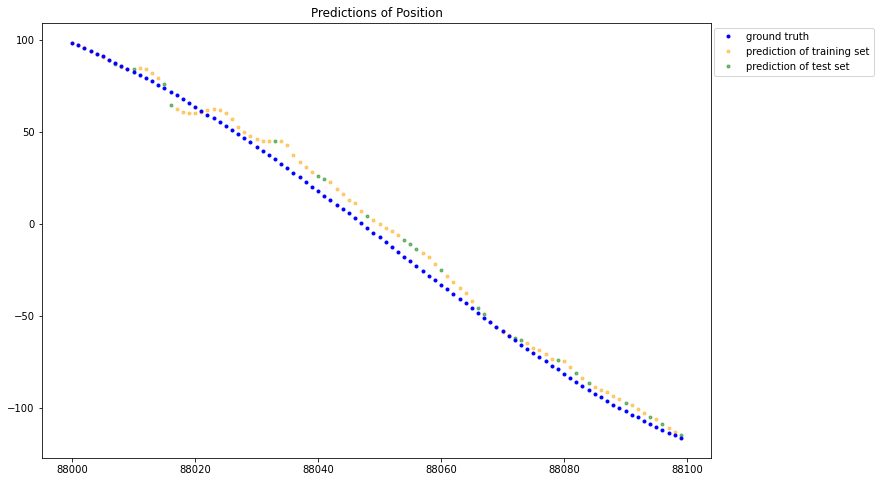

In [104]:
# middle speed area
F = 88000
L = F+100
plot_one_gt_train_test_dot_rmse(Y,y_,idx_train_sort,idx_test_sort,F,L,"Predictions of Position")